## 导入必要的包

In [1]:
%matplotlib inline

In [2]:
import torch
import sys
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from torchsummary import summary
import math
from sklearn.manifold import TSNE

## CNN网络

### 数据获取与处理

torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)

&ensp;&ensp;&ensp;&ensp;root (string): 数据集存储的目录`MNIST/processed/training.pt`以及`MNIST/processed/test.pt`存在的位置

&ensp;&ensp;&ensp;&ensp;train (bool, optional): 如果为`True`从training.pt创建数据集，否则从test.pt。主要作用就是指定创建训练集还是验证集

&ensp;&ensp;&ensp;&ensp;download (bool, optional): 如果为`True`就下载数据集到目标目录，否则不下载，但必须保证数据集已经存在

&ensp;&ensp;&ensp;&ensp;transform (callable, optional): 类型转换，主要将数据转换为`Tensor`类型

&ensp;&ensp;&ensp;&ensp;target_transform (callable, optional): 类型转换，转换标签数据为`Tensor`类型

In [3]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=False,
)

In [4]:
print('训练集数据维度: ', train_data.data.size(), '\n训练集标签维度: ', train_data.targets.size())

训练集数据维度:  torch.Size([60000, 28, 28]) 
训练集标签维度:  torch.Size([60000])


### 训练数据可视化

In [5]:
def plot_num_images(num):
    if num < 1:
        print('INFO:The number of input pictures must be greater than zero!')
    else:
        choose_list = []
        for i in range(num):
            choose_n = np.random.randint(train_data.data.size()[0])
            choose_list.append(choose_n)
        fig = plt.gcf()
        fig.set_size_inches(10, 3.5 * math.ceil(num / 3))
        for i in range(num):
            ax_img = plt.subplot(math.ceil(num / 3), 3, i + 1)
            plt_img = train_data.data[choose_list[i]].numpy()
            ax_img.imshow(plt_img, cmap='binary')
            ax_img.set_title('label:' + str(train_data.targets[choose_list[i]].item()),
                             fontsize=10)
        plt.show()


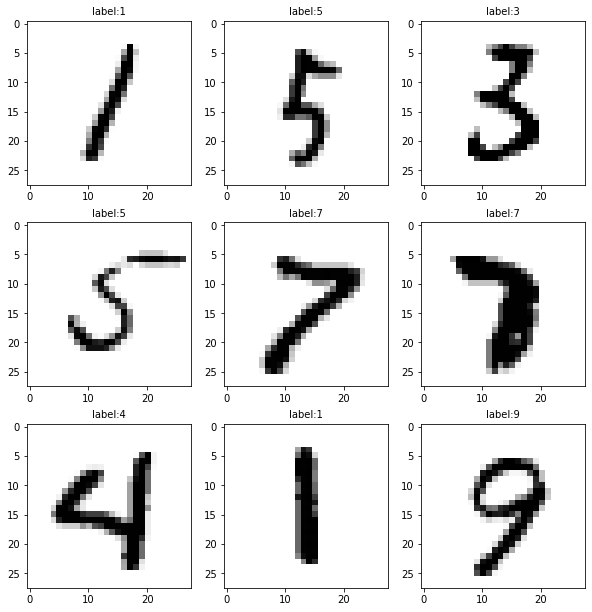

In [6]:
plot_num_images(9)

### 制作数据装载器及迭代器

设置批次大小

In [7]:
BATCH_SIZE = 50

训练数据装载器

In [8]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

测试数据读取

In [9]:
test_data = torchvision.datasets.MNIST(root='./mnist/', transform=torchvision.transforms.ToTensor(), train=False)

In [10]:
print('测试集数据维度: ', test_data.data.size(), '\n测试集标签维度: ', test_data.targets.size())

测试集数据维度:  torch.Size([10000, 28, 28]) 
测试集标签维度:  torch.Size([10000])


测试数据装载器

In [11]:
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE * 10, shuffle=True)

### 获取设备信息

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


### 简易CNN网络构建

In [13]:
class CNN(nn.Module):
    '''
    第一层:28x28x1
    第二层:14x14x16
    第三层:7x7x32
    '''
    def __init__(self):
        super(CNN, self).__init__()
        # 第一层卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # 第二层卷积
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # 输出层
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)

        return output, x

获取CNN网络摘要`summary`

In [14]:
cnn = CNN().to(device)

summary(cnn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 10]          15,690
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.11
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


### 开始训练

设置超参数

In [15]:
EPOCHS = 1
LR = 0.001
STEPS=200

指定优化器与损失函数

In [16]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

定义权重重置函数

In [17]:
def weight_reset(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        m.reset_parameters()

In [18]:
def plot_with_labels(lowDWeights, labels):
    fig = plt.figure()
    fig.set_size_inches(15, 15)
    ax = fig.gca(projection='3d')

    X, Y, Z = lowDWeights[:, 0], lowDWeights[:, 1], lowDWeights[:, 2]
    
    for x, y, z, s in zip(X, Y, Z, labels):
        c = cm.rainbow(int(255 * s / 9))
        ax.text(x, y, z, s, backgroundcolor=c)
    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    ax.set_zlim(Z.min(), Z.max())

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.show()

开始训练

Only EPOCH 1, step=200/200, train_loss=0.5322, train_acc=0.9000, valid_loss=0.1628, val_acc=0.9480

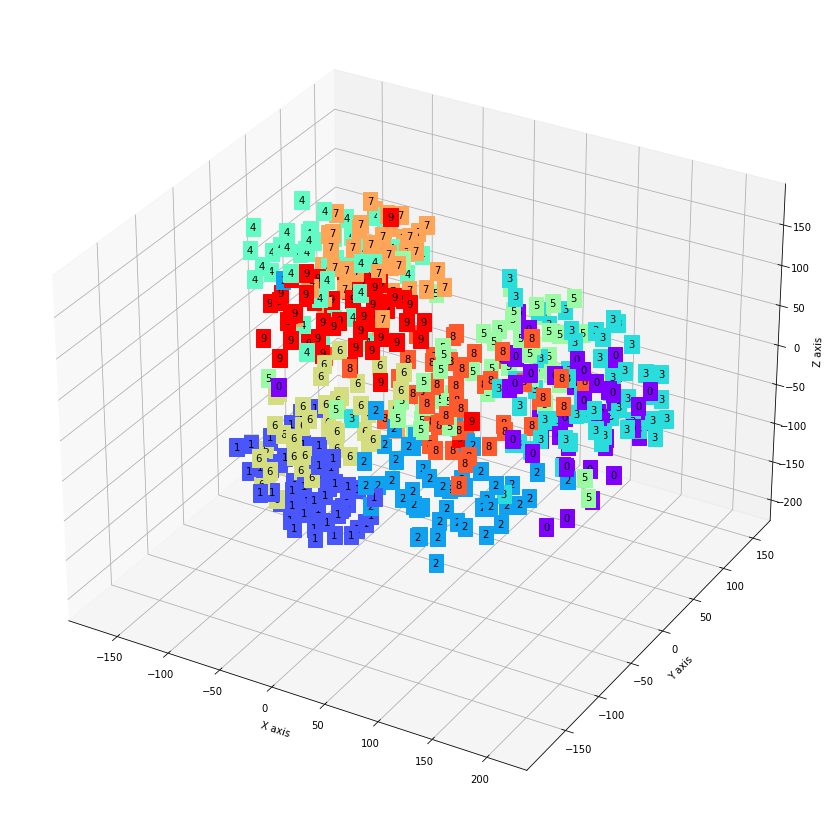

Wall time: 58.7 s


In [19]:
%%time

# 权重初始化
cnn.apply(weight_reset)

# 建立迭代器iter
dataiter = iter(test_loader)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(EPOCHS):
    for step, data in enumerate(train_loader):
        # 数据提取并转为GPU形式
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 结果预测并获取预测值
        outputs = cnn(inputs)[0]
        train_pred_y = torch.max(outputs, 1)[1].data.squeeze()
        # 获取准确率
        train_acc = (train_pred_y == labels).sum().item() / float(labels.size(0))
        # 获取损失值
        loss = loss_func(outputs, labels)
        train_loss_list.append(float(loss))
        train_acc_list.append(train_acc)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 异常处理标志
        try:
            images, targets = next(dataiter)
        except StopIteration:
            dataiter = iter(test_loader)
            images, targets = next(dataiter)
        
        # 数据提取并转为GPU形式
        images, targets = next(dataiter)
        images, targets = images.to(device), targets.to(device)
        # 结果预测并获取预测值
        test_outputs, last_layer = cnn(images)
        test_pred_y = torch.max(test_outputs, 1)[1].data.squeeze()
        # 获取准确率
        test_acc = (test_pred_y == targets).sum().item() / float(targets.size(0))
        test_acc_list.append(test_acc)
        # 获取损失值
        test_loss = loss_func(test_outputs, targets)
        test_loss_list.append(float(test_loss))
        
        sys.stdout.write(('\rOnly EPOCH 1, step={:3d}/{:3d}, train_loss={:.4f}, '
               'train_acc={:.4f}, valid_loss={:.4f}, val_acc={:.4f}').format(step + 1,
                                                                    STEPS,
                                                                    loss,
                                                                    train_acc,
                                                                    test_loss,
                                                                    test_acc))
        if step == STEPS-1:
            # 绘制出图像的数量最大值取决于数据的batchsize大小
            tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000)
            low_dim_embs = tsne.fit_transform(last_layer.cpu().detach().numpy())
            labels = targets.cpu().numpy()
            plot_with_labels(low_dim_embs, labels)
            break

### 训练效果可视化

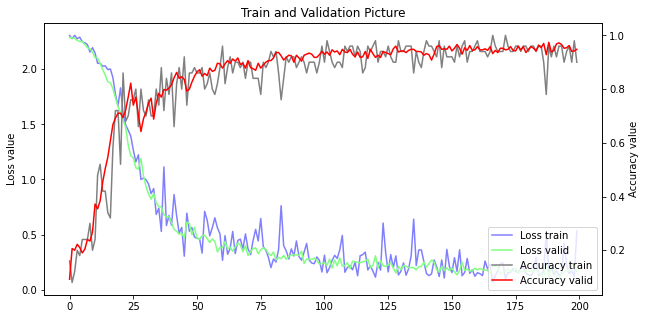

In [20]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax1 = fig.add_subplot(111)
ax1.set_title('Train and Validation Picture')
ax1.set_ylabel('Loss value')
line1, = ax1.plot(train_loss_list, color=(0.5, 0.5, 1.0), label='Loss train')
line2, = ax1.plot(test_loss_list, color=(0.5, 1.0, 0.5), label='Loss valid')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy value')
line3, = ax2.plot(train_acc_list, color=(0.5, 0.5, 0.5), label='Accuracy train')
line4, = ax2.plot(test_acc_list, color=(1, 0, 0), label='Accuracy valid')
plt.legend(handles=(line1, line2, line3, line4), loc='best')
plt.show()

### 获取测试集每类准去率

In [21]:
'''
设计思想：将每一类预测值与真实值进行对比，正确的为True
错误的为False，然后将所有的预测True相加，得到总的
预测正确的，最后除以总数量，得到每一类的正确率
'''

# 创建一个10维列表，存储后面每个类累计的值
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # 独热码类型分布，输出为4x10的矩阵，分别表示batchsize：4以及类别：10
        outputs = cnn(images)[0]
        _, predicted = torch.max(outputs, 1)
        # 将输入张量形状中的 1 去除并返回，例如[1, 2, 3]
        # 返回[2, 3]，当给定 dim 时，那么挤压操作只在给定维度
        # 在这里由于返回的bool值，可以不使用.squeeze()操作
        c = (predicted == labels).squeeze()
        # 循环遍历每一个批次
        for i in range(500):
            label = labels[i]
            # 获取具体值
            class_correct[label] += c[i].item()
            # 对应类别自加
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 96 %
Accuracy of 1 : 97 %
Accuracy of 2 : 91 %
Accuracy of 3 : 99 %
Accuracy of 4 : 96 %
Accuracy of 5 : 92 %
Accuracy of 6 : 98 %
Accuracy of 7 : 93 %
Accuracy of 8 : 91 %
Accuracy of 9 : 89 %


## 显存释放

In [22]:
torch.cuda.empty_cache()

## DNN网络

**注意：本节沿用前面的数据处理，设备信息，重置函数等**

### 构建简易DNN模型

In [23]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.dnn = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, inputs):
        return self.dnn(inputs)

In [24]:
dnn = DNN().to(device)

summary(dnn, input_size=(784, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          50,240
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 10]             330
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


### 开始训练

构造优化器，损失函数与`CNN`相同

In [25]:
optimizer = torch.optim.Adam(dnn.parameters(), lr=LR)

开始训练

In [26]:
# 权重初始化
dnn.apply(weight_reset)

# 建立迭代器iter
dataiter = iter(test_loader)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(EPOCHS):
    for step, data in enumerate(train_loader):
        # 数据提取并转为GPU形式
        inputs, labels = data
        # 调整维度为784输入形式
        inputs, labels = inputs.view([-1, 784]).to(device), labels.to(device)
        # 结果预测并获取预测值
        outputs = dnn(inputs)
        train_pred_y = torch.max(outputs, 1)[1].data.squeeze()
        # 获取准确率
        train_acc = (train_pred_y == labels).sum().item() / float(labels.size(0))
        # 获取损失值
        loss = loss_func(outputs, labels)
        train_loss_list.append(loss.cpu().detach().numpy())
        train_acc_list.append(train_acc)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 异常处理标志
        try:
            images, targets = next(dataiter)
        except StopIteration:
            dataiter = iter(test_loader)
            images, targets = next(dataiter)
        
        # 数据提取并转为GPU形式
        images, targets = next(dataiter)
        # 调整维度为784输入形式
        images, targets = images.view([-1, 784]).to(device), targets.to(device)
        # 结果预测并获取预测值
        test_outputs = dnn(images)
        test_pred_y = torch.max(test_outputs, 1)[1].data.squeeze()
        # 获取准确率
        test_acc = (test_pred_y == targets).sum().item() / float(targets.size(0))
        test_acc_list.append(test_acc)
        # 获取损失值
        test_loss = loss_func(test_outputs, targets)
        test_loss_list.append(test_loss)
        
        print(('Only EPOCH 1, step={:3d}/{:3d}, train_loss={:.4f}, '
               'train_acc={:.4f}, valid_loss={:.4f}, val_acc={:.4f}').format(step + 1,
                                                                    STEPS,loss.cpu().detach().numpy(),
                                                                    train_acc,
                                                                    test_loss.cpu().detach().numpy(),
                                                                    test_acc))
        if step == STEPS-1:
            break

Only EPOCH 1, step=  1/200, train_loss=2.3101, train_acc=0.1000, valid_loss=2.2895, val_acc=0.1040
Only EPOCH 1, step=  2/200, train_loss=2.2876, train_acc=0.1000, valid_loss=2.2929, val_acc=0.0880
Only EPOCH 1, step=  3/200, train_loss=2.2973, train_acc=0.1000, valid_loss=2.2793, val_acc=0.1180
Only EPOCH 1, step=  4/200, train_loss=2.2723, train_acc=0.1600, valid_loss=2.2575, val_acc=0.1500
Only EPOCH 1, step=  5/200, train_loss=2.2470, train_acc=0.1200, valid_loss=2.2581, val_acc=0.1380
Only EPOCH 1, step=  6/200, train_loss=2.2328, train_acc=0.2400, valid_loss=2.2445, val_acc=0.1680
Only EPOCH 1, step=  7/200, train_loss=2.2757, train_acc=0.0600, valid_loss=2.2285, val_acc=0.2140
Only EPOCH 1, step=  8/200, train_loss=2.2522, train_acc=0.1600, valid_loss=2.2131, val_acc=0.2580
Only EPOCH 1, step=  9/200, train_loss=2.2120, train_acc=0.3000, valid_loss=2.1965, val_acc=0.2600
Only EPOCH 1, step= 10/200, train_loss=2.1720, train_acc=0.3600, valid_loss=2.2000, val_acc=0.2540
Only EPOCH

Only EPOCH 1, step= 84/200, train_loss=0.8380, train_acc=0.7800, valid_loss=0.6340, val_acc=0.8240
Only EPOCH 1, step= 85/200, train_loss=0.7552, train_acc=0.8600, valid_loss=0.6707, val_acc=0.8120
Only EPOCH 1, step= 86/200, train_loss=0.6958, train_acc=0.8000, valid_loss=0.6282, val_acc=0.8260
Only EPOCH 1, step= 87/200, train_loss=0.5289, train_acc=0.9200, valid_loss=0.6463, val_acc=0.8240
Only EPOCH 1, step= 88/200, train_loss=0.7054, train_acc=0.7400, valid_loss=0.6176, val_acc=0.8300
Only EPOCH 1, step= 89/200, train_loss=0.7685, train_acc=0.7600, valid_loss=0.6548, val_acc=0.8300
Only EPOCH 1, step= 90/200, train_loss=0.7007, train_acc=0.8400, valid_loss=0.6000, val_acc=0.8260
Only EPOCH 1, step= 91/200, train_loss=0.6658, train_acc=0.8000, valid_loss=0.6266, val_acc=0.8380
Only EPOCH 1, step= 92/200, train_loss=0.9402, train_acc=0.6400, valid_loss=0.6270, val_acc=0.8380
Only EPOCH 1, step= 93/200, train_loss=0.6961, train_acc=0.8400, valid_loss=0.5861, val_acc=0.8280
Only EPOCH

Only EPOCH 1, step=167/200, train_loss=0.3339, train_acc=0.9200, valid_loss=0.4263, val_acc=0.8860
Only EPOCH 1, step=168/200, train_loss=0.3698, train_acc=0.9000, valid_loss=0.4261, val_acc=0.8820
Only EPOCH 1, step=169/200, train_loss=0.2948, train_acc=0.9600, valid_loss=0.3837, val_acc=0.8880
Only EPOCH 1, step=170/200, train_loss=0.5796, train_acc=0.8200, valid_loss=0.4193, val_acc=0.8860
Only EPOCH 1, step=171/200, train_loss=0.4341, train_acc=0.8600, valid_loss=0.4345, val_acc=0.8620
Only EPOCH 1, step=172/200, train_loss=0.5695, train_acc=0.8400, valid_loss=0.4601, val_acc=0.8580
Only EPOCH 1, step=173/200, train_loss=0.5970, train_acc=0.8600, valid_loss=0.4074, val_acc=0.8760
Only EPOCH 1, step=174/200, train_loss=0.3963, train_acc=0.8800, valid_loss=0.4897, val_acc=0.8600
Only EPOCH 1, step=175/200, train_loss=0.4140, train_acc=0.8400, valid_loss=0.4894, val_acc=0.8520
Only EPOCH 1, step=176/200, train_loss=0.4662, train_acc=0.8200, valid_loss=0.4038, val_acc=0.8680
Only EPOCH

### 训练效果可视化

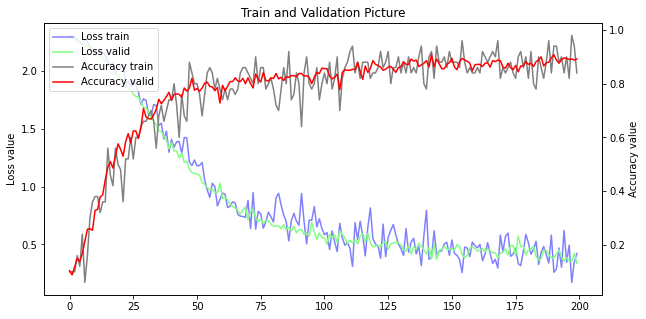

In [27]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax1 = fig.add_subplot(111)
ax1.set_title('Train and Validation Picture')
ax1.set_ylabel('Loss value')
line1, = ax1.plot(train_loss_list, color=(0.5, 0.5, 1.0), label='Loss train')
line2, = ax1.plot(test_loss_list, color=(0.5, 1.0, 0.5), label='Loss valid')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy value')
line3, = ax2.plot(train_acc_list, color=(0.5, 0.5, 0.5), label='Accuracy train')
line4, = ax2.plot(test_acc_list, color=(1, 0, 0), label='Accuracy valid')
plt.legend(handles=(line1, line2, line3, line4), loc='best')
plt.show()

### 获取每类测试准确率

In [28]:
'''
设计思想：将每一类预测值与真实值进行对比，正确的为True
错误的为False，然后将所有的预测True相加，得到总的
预测正确的，最后除以总数量，得到每一类的正确率
'''

# 创建一个10维列表，存储后面每个类累计的值
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.view([-1, 784]).to(device), labels.to(device)
        # 独热码类型分布，输出为4x10的矩阵，分别表示batchsize：4以及类别：10
        outputs = dnn(images)
        _, predicted = torch.max(outputs, 1)
        
        # 将输入张量形状中的 1 去除并返回，例如[1, 2, 3]
        # 返回[2, 3]，当给定 dim 时，那么挤压操作只在给定维度
        # 在这里由于返回的bool值，可以不使用.squeeze()操作
        c = (predicted == labels).squeeze()
        # 循环遍历每一个批次
        for i in range(50):
            label = labels[i]
            # 获取具体值
            class_correct[label] += c[i].item()
            # 对应类别自加
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 95 %
Accuracy of 1 : 99 %
Accuracy of 2 : 89 %
Accuracy of 3 : 86 %
Accuracy of 4 : 81 %
Accuracy of 5 : 86 %
Accuracy of 6 : 93 %
Accuracy of 7 : 87 %
Accuracy of 8 : 74 %
Accuracy of 9 : 90 %
